In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import os
from pathlib import Path

import numpy as np
import torch
from torch.utils.data import DataLoader, Subset

from vit_prisma.utils.constants import BASE_DIR, DATA_DIR, MODEL_DIR, DEVICE, MODEL_CHECKPOINTS_DIR
from vit_prisma.utils.tutorial_utils import calculate_clean_accuracy, load_clip_models, plot_image, get_feature_activations
from vit_prisma.utils.data_utils.loader import load_dataset
from vit_prisma.sae.config import VisionModelSAERunnerConfig
from vit_prisma.sae.train_sae import VisionSAETrainer
from vit_prisma.utils.tutorial_utils import plot_act_distribution
from vit_prisma.utils.tutorial_utils import plot_top_imgs_for_features

# Prisma SAE Tutorial

This tutorial is a quick start guide on how to load, evaluate, and train SAEs with Prisma. It uses ImageNet as an extended example.

# Setup

Ensure you have ImageNet data locally (you will need to have a Kaggle account).

```
python3 -m venv myenv
source myenv/bin/activate
pip install -e .
pip install kaggle
cd data
kaggle competitions download -c imagenet-object-localization-challenge
```

## Loading pre-trained SAE

Prisma has trained several SAEs for different architectures that can be found on HuggingFace [here](https://huggingface.co/Prisma-Multimodal). Here we will use a CLIP SAE trained on ImageNet. 

In [ ]:
# Load an SAE
from huggingface_hub import hf_hub_download, list_repo_files
from vit_prisma.sae import SparseAutoencoder

def load_sae(repo_id, file_name, config_name):
    # Step 1: Download SAE from Hugginface
    sae_path = hf_hub_download(repo_id, file_name) # Download weights
    hf_hub_download(repo_id, config_name) # Download config

    # Step 2: Load the pretrained SAE weights from the downloaded path
    print(f"Loading SAE from {sae_path}...")
    sae = SparseAutoencoder.load_from_pretrained(sae_path) # This now automatically gets config.json and converts into the VisionSAERunnerConfig object
    return sae

repo_id = "Prisma-Multimodal/sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-11-hook_resid_post-l1-1e-05" # Change this to your chosen SAE. See /docs for a list of SAEs.
file_name = "weights.pt" # Usually weights.pt but may have slight naming variation. See the original HF repo for the exact file name
config_name = "config.json"
sae = load_sae(repo_id, file_name, config_name)

Loading SAE from /home/mila/s/sonia.joseph/.cache/huggingface/hub/models--Prisma-Multimodal--sparse-autoencoder-clip-b-32-sae-vanilla-x64-layer-11-hook_resid_post-l1-1e-05/snapshots/2b1cb17ffb8b06e7f45a699dfc97d417f9879be4/weights.pt...


Let's look at the sae's config and examine some details. In particular, we confirm that it was trained on the layer 11 residual stream of the base model `open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K`.

In [8]:

from pprint import pprint
sae.cfg
pprint(sae.cfg)

VisionModelSAERunnerConfig(model_class_name='HookedViT',
                           model_name='open-clip:laion/CLIP-ViT-B-32-DataComp.XL-s13B-b90K',
                           vit_model_cfg=None,
                           model_path=None,
                           hook_point_layer=11,
                           layer_subtype='hook_resid_post',
                           hook_point_head_index=None,
                           context_size=50,
                           use_cached_activations=False,
                           use_patches_only=False,
                           cached_activations_path='activations/_network_scratch_s_sonia.joseph_datasets_kaggle_datasets/open-clip:laion_CLIP-ViT-B-32-DataComp.XL-s13B-b90K/blocks.9.hook_mlp_out',
                           image_size=224,
                           architecture='standard',
                           b_dec_init_method='geometric_median',
                           expansion_factor=64,
                           from_pretrai

## Load pretrained model

Let's load the pretrained CLIP model using the `load_hooked_model` function. The function loads the pretrained CLIP weights from Huggingface and puts the weights into our HookedViT object so that we can readily grab the intermediate activations.

In [12]:
# Load model
from vit_prisma.models.model_loader import load_hooked_model

model_name = sae.cfg.model_name
model = load_hooked_model(model_name)

## Load dataset

In [ ]:
# Put paths here

def load_imagenet(imagenet_validation_path):
    torch.set_grad_enabled(False)

    data_transforms = get_clip_val_transforms()
    val_data = torchvision.datasets.ImageFolder(imagenet_validation_path, transform=data_transforms)
    
    if args.verbose:
        print(f"Validation data length: {len(val_data)}")
    
    val_dataloader = DataLoader(val_data, batch_size=args.batch_size, shuffle=False, num_workers=4)
    
    return val_dataloader

# Put your imagenet path here. You can download ImageNet from kaggle.
imagenet_validation_path = '/network/scratch/s/sonia.joseph/datasets/kaggle_datasets/ILSVRC/Data/CLS-LOC/val'

In [ ]:
val_dataloader = load_imagenet

KeyboardInterrupt: 

In [14]:
subset_indices = torch.randperm(len(test_data))[:50]
subset_dataset = Subset(test_data, subset_indices)
dataloader = DataLoader(subset_dataset, batch_size=32, num_workers=0, pin_memory=True, shuffle=False)

In [29]:
data = next(iter(dataloader))

IsADirectoryError: [Errno 21] Is a directory: '/network/scratch/s/sonia.joseph/datasets/kaggle_datasets/ILSVRC/Data/CLS-LOC/val/n02442845'

## Load classifier

In [27]:
from tqdm import tqdm
def calculate_clean_accuracy(
    net,
    classifier: torch.Tensor,
    data_loader,
    device=DEVICE,
    top_k: int = 1,
    sae: SparseAutoencoder = None,
):
    """Calculate the top k clean accuracy of a CLIPmodel on a dataset."""

    net.eval()
    correct = 0
    total = 0

    for batch in tqdm(data_loader):
        images = batch[0].to(device)
        labels = batch[1].to(device)

        with torch.no_grad():
            logits = sae.get_test_loss(images, net) if sae else net(images)
            logits = 100.0 * logits @ classifier
            preds = logits.topk(top_k)[1].t()[0]
            correct += preds.eq(labels).sum().item()
            total += len(labels)

        torch.cuda.empty_cache()

    accuracy = correct / total if total > 0 else 0
    return accuracy, total

CLIP can work as a zero-shot classifier. Because it learns a joint embedding space for both images and text during pre-training, it can match new images with text descriptions of the classes without requiring any examples of the target classes during inference. Here we load the text embeddings of the class names from file.

In [28]:
classifier_npy_path = '../pretrained_classifiers/clip_benchmark/imagenet_classifier_hf_hub_laion_CLIP_ViT_B_32_DataComp.XL_s13B_b90K.npy'
classifier_class_vectors = np.load(classifier_npy_path)
classifier_class_vectors = torch.from_numpy(classifier_class_vectors).to(DEVICE)

calculate_clean_accuracy(model, classifier_class_vectors, dataloader)

  0%|          | 0/2 [00:00<?, ?it/s]


IsADirectoryError: [Errno 21] Is a directory: '/network/scratch/s/sonia.joseph/datasets/kaggle_datasets/ILSVRC/Data/CLS-LOC/val/n02442845'

Now we load a particular image to put through the SAE:

Unstandardising image


/var/folders/72/_bc632k57_z3csy891xg0tj80000gp/T/ipykernel_44394/2199321972.py:2: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



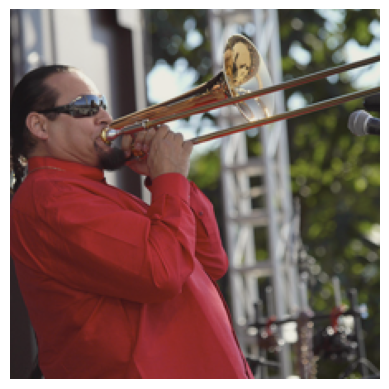

: 

: 

In [ ]:
example_image_idx = 12
example_img_tensor = torch.tensor(subset_dataset[example_image_idx][0]).to(DEVICE)
example_img_idx = torch.tensor(subset_dataset[example_image_idx][1]).item()
plot_image(example_img_tensor.detach().cpu(), unstandardise=True)

In [ ]:
ref_imgs_per_feat = torch.load(BASE_DIR / "demos/reference_images_by_activation_magnitude.pt", weights_only=False)

: 

: 

In [ ]:
top_indices, _ = plot_act_distribution(
    get_feature_activations(example_img_tensor.unsqueeze(0), model, sae)[0, 0, :],
    n_top=10
)

Top 10 feature indices: [33201, 22835, 45496, 9568, 27766, 45641, 4857, 5819, 35628, 32519]
Top 10 feature values: [0.8184767 1.1136707 1.1139154 1.2114868 2.4046667 2.6790802 3.1853724
 4.696858  5.8784633 6.753027 ]


: 

: 

In [ ]:
top_indices

array([ 7077, 11073, 32519])

: 

: 

Feature 32519 (Rank 9): Top Images: [12665 35223 45545 39381 41588 32437  1457 48545 44144  8785], Activations: [0.62889326 0.481641   0.46173707 0.45443457 0.45068634 0.4502227
 0.4405331  0.43832237 0.4379796  0.43624648]


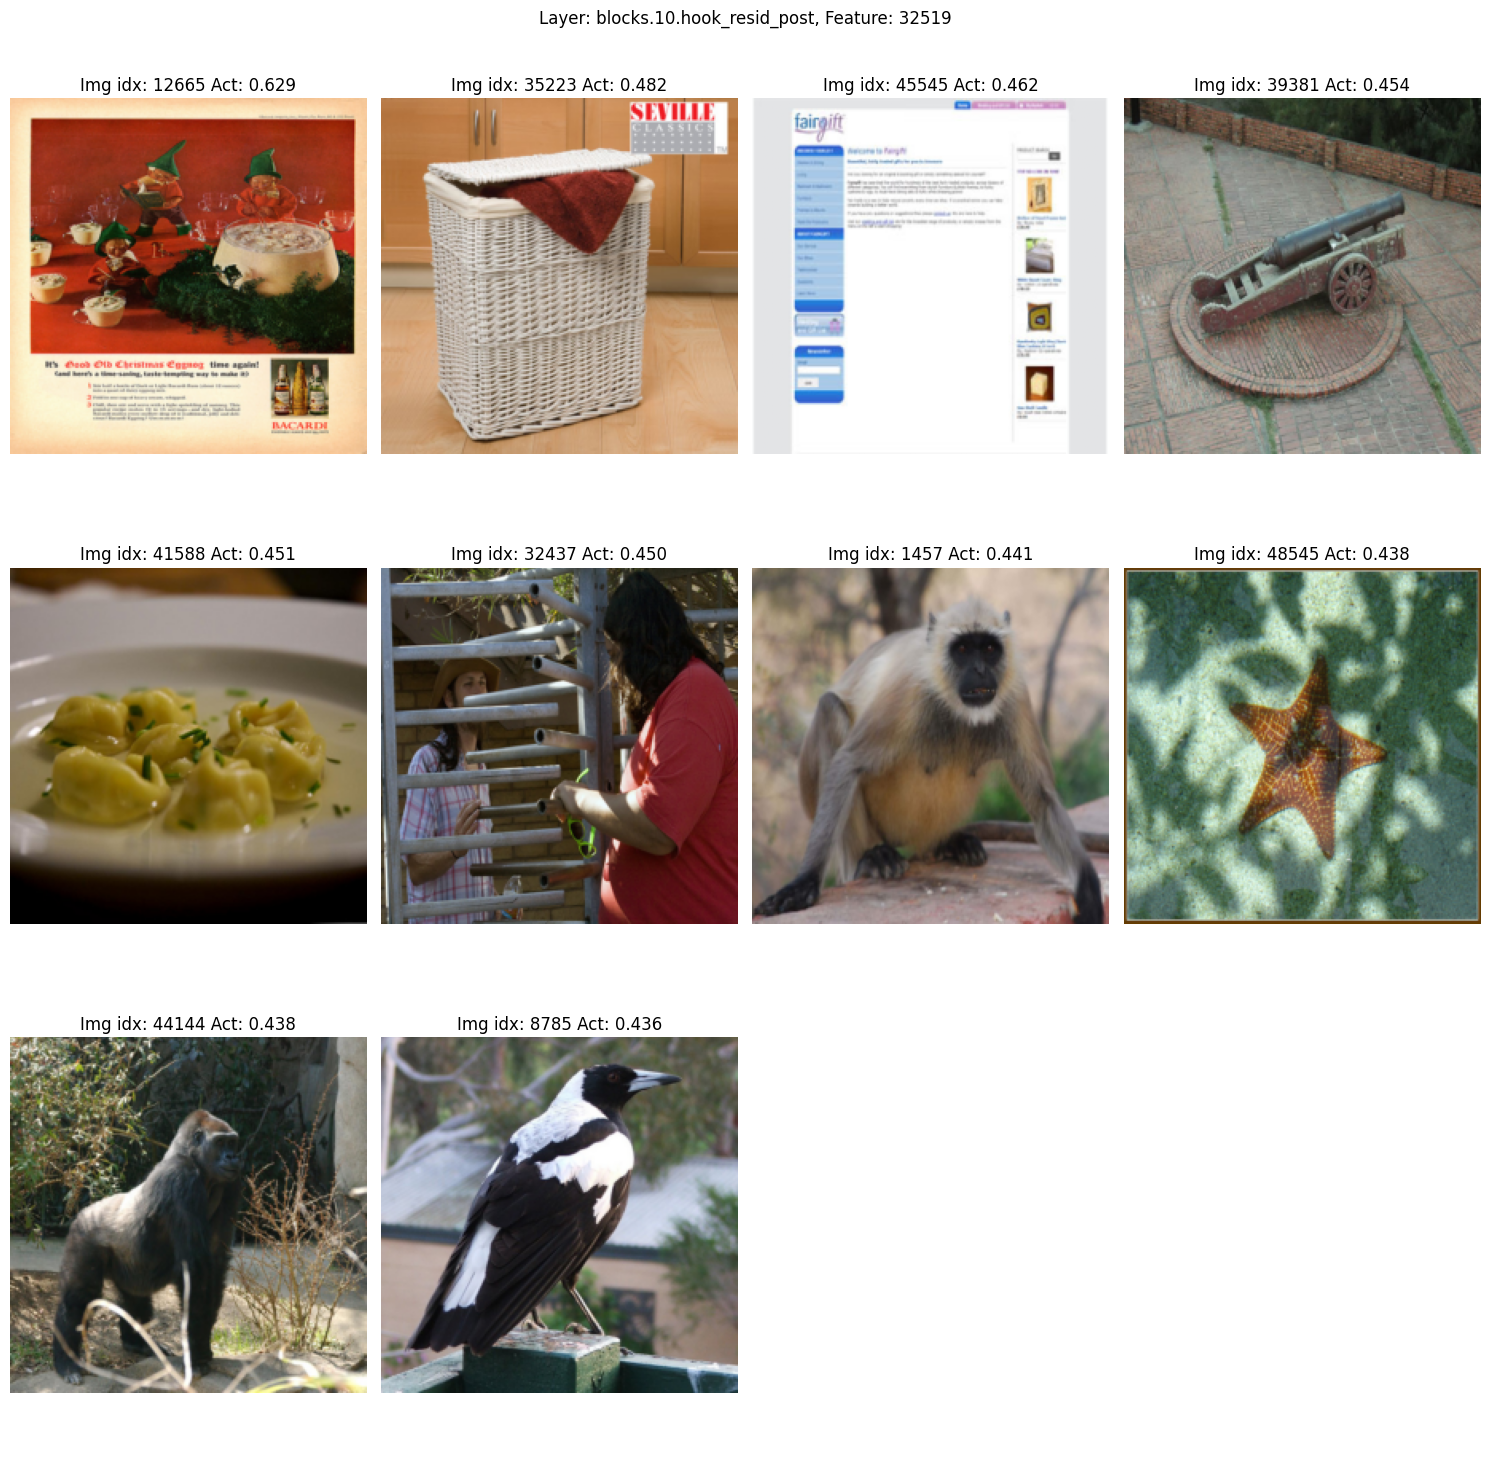

: 

: 

In [ ]:
plot_top_imgs_for_features(
    top_indices,
    ref_imgs_per_feat,
    viz_data,
    sae,
    top_k=1
)

# Train an SAE

First we need a model - you can either load one or use Prisma to train:

In [ ]:
from vit_prisma.models.base_vit import HookedViT
from vit_prisma.training import trainer


sae_config = VisionModelSAERunnerConfig(
    num_epochs=10,
    n_checkpoints=5,
    log_to_wandb=False,
    verbose=True,
    wandb_log_frequency=1,
    dataset_name="imagenet",
    dataset_path=str(DATA_DIR / "imagenet"),
    train_batch_size=1024,
    hook_point_layer=3,
    device=DEVICE,
    total_training_images=48000,
    total_training_tokens=48000 * 65 * 10,
    model_name="local/imagenet",
    sae_path=str(MODEL_DIR / "sae/imagenet/checkpoints"),
    context_size=65,
    image_size=128,
)

model_function = HookedViT
trainer.train(
    model_function,
    sae_config,
    train_dataset=train_data,
    val_dataset=test_data,
)

: 

: 

Now we can train the SAE:

In [ ]:
sae_train_cfg = VisionModelSAERunnerConfig(
    model_name="local/imagenet",
    hook_point_layer=3,
    d_in=384,
    context_size=65,
    dataset_name="imagenet",
    dataset_path=str(DATA_DIR / "imagenet"),
    dataset_train_path=str(DATA_DIR / "imagenet/ILSVRC/Data/CLS-LOC/train"),
    dataset_val_path=str(DATA_DIR / "imagenet/ILSVRC/Data/CLS-LOC/val"),
    feature_sampling_window=1000,
)

trainer = VisionSAETrainer(sae_train_cfg)
sae = trainer.run()

: 

: 

# Evaluate the SAE

This notebook is still under development - check back soon!

In [ ]:
evaluator = Evaluator(model, test_data, cfg)
evaluator.evaluate(sae, context=EvaluationContext.POST_TRAINING)

: 

: 